In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the directories for images and masks
image_dir = r'C:\Users\nikhi\Downloads\archive (1)\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_19991127'  
mask_dir = r'C:\Users\nikhi\Downloads\archive (1)\lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_19991127'  

# Function to read and resize images
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for image_file in os.listdir(image_dir):
        img = cv2.imread(os.path.join(image_dir, image_file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        images.append(img)
        
        # Load corresponding mask
        mask_file = image_file.replace('.jpg', '_mask.jpg')  
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        masks.append(mask)
    
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)
    return images, masks

# Load dataset
images, masks = load_data(image_dir, mask_dir)

# Normalize the images and masks
images = images / 255.0
masks = masks / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [3]:
from tensorflow.keras import layers, models

# U-Net model definition
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                       

Epoch 1/20


8/8 [==============================] - 31s 4s/step - loss: 0.5084 - accuracy: 0.5067 - val_loss: 0.1913 - val_accuracy: 0.6711
Epoch 2/20
8/8 [==============================] - 32s 4s/step - loss: 0.1582 - accuracy: 0.5186 - val_loss: 0.0785 - val_accuracy: 0.6711
Epoch 3/20
8/8 [==============================] - 33s 4s/step - loss: 0.1103 - accuracy: 0.5186 - val_loss: 0.0718 - val_accuracy: 0.6711
Epoch 4/20
8/8 [==============================] - 34s 4s/step - loss: 0.0988 - accuracy: 0.5186 - val_loss: 0.0691 - val_accuracy: 0.6711
Epoch 5/20
8/8 [==============================] - 32s 4s/step - loss: 0.0951 - accuracy: 0.5186 - val_loss: 0.0679 - val_accuracy: 0.6711
Epoch 6/20
8/8 [==============================] - 32s 4s/step - loss: 0.0936 - accuracy: 0.5186 - val_loss: 0.0670 - val_accuracy: 0.6711
Epoch 7/20
8/8 [==============================] - 47s 6s/step - loss: 0.0926 - accuracy: 0.5186 - val_loss: 0.0664 - val_accuracy: 0.6711
Epoch 8/20
8/8 [================

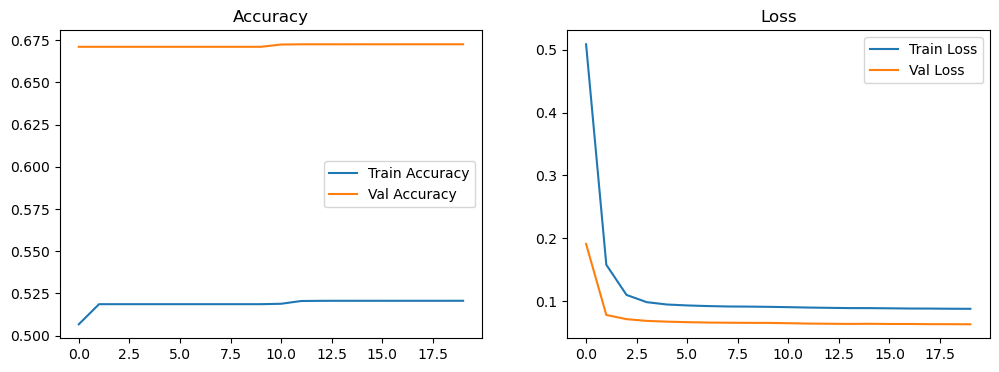

In [4]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=16)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# Show the plots
plt.show()


2/2 [==============================] - 2s 223ms/step - loss: 0.0854 - accuracy: 0.5360
Test accuracy: 0.5360
2/2 [==============================] - 2s 213ms/step


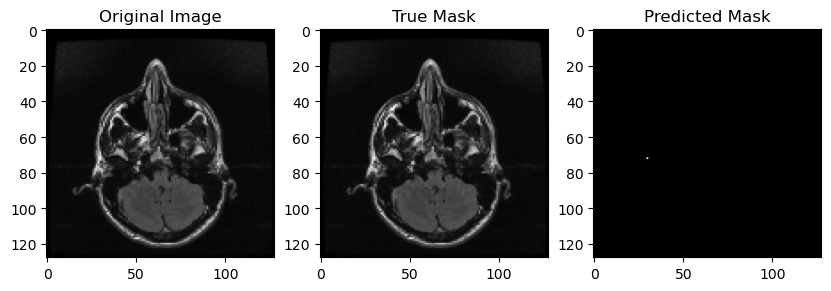

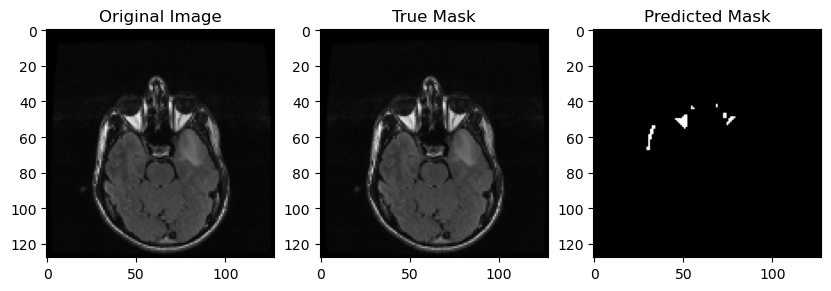

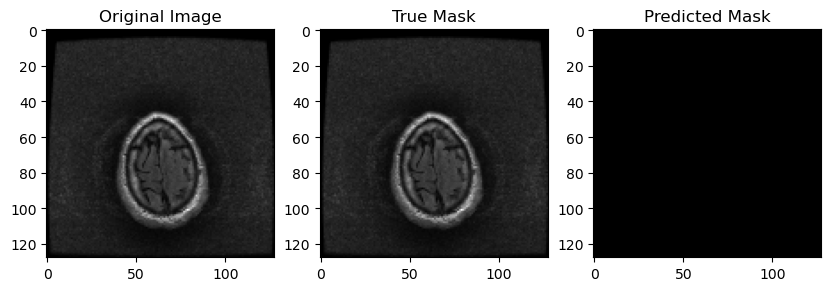

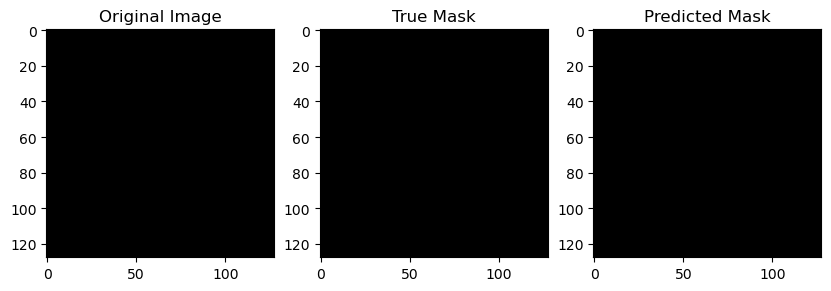

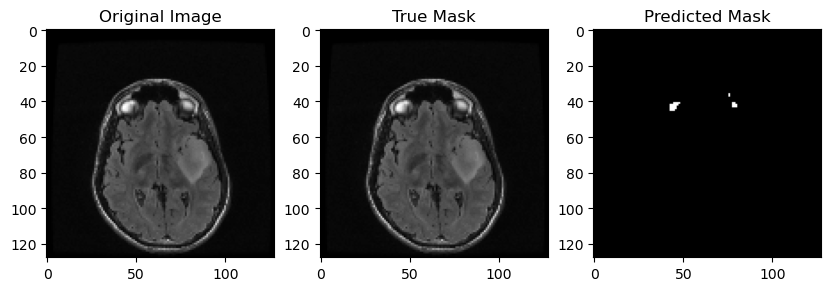

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Predict on test images
predictions = model.predict(X_test)

# Threshold the predictions to create binary masks (for segmentation)
predictions = (predictions > 0.5).astype(np.uint8)

# Display some test images with their true and predicted masks
for i in range(5):
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title("Original Image")
    
    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
    plt.title("True Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
    plt.title("Predicted Mask")
    
    # Show the plots
    plt.show()


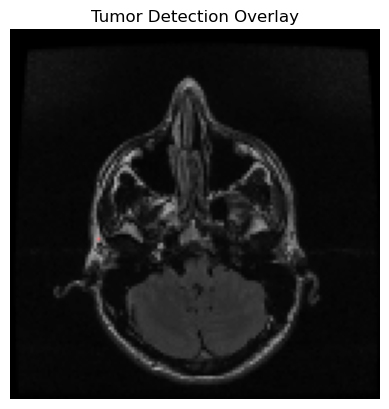

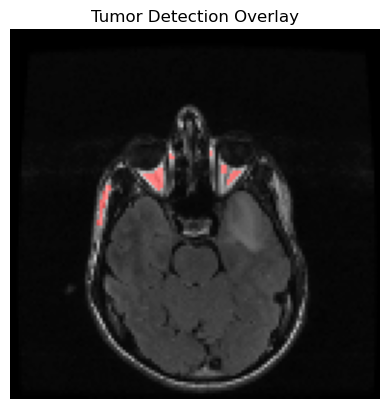

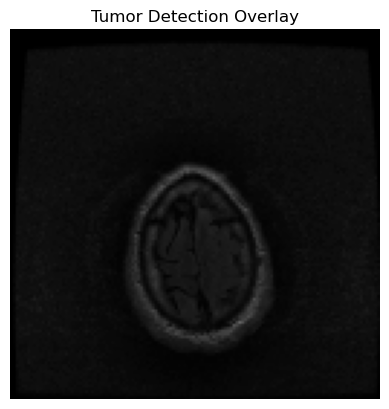

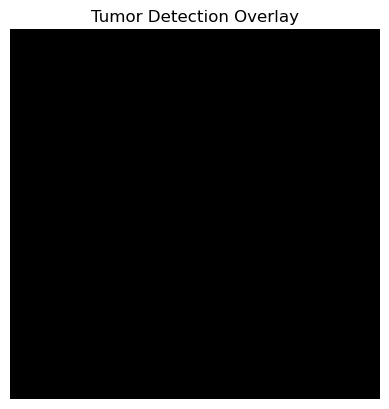

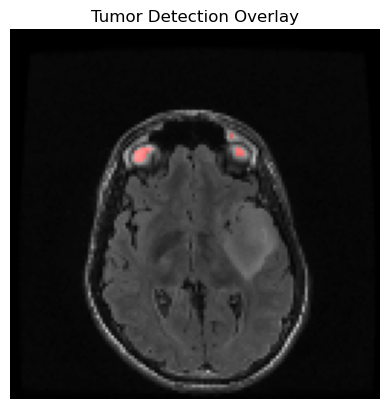

In [8]:
def overlay_mask(image, mask, alpha=0.5):
    """Overlay the mask on the image."""
    overlay = image.copy()

    # Apply red color to the mask area (tumor region)
    overlay[mask > 0] = [255, 0, 0]  # Red color for the tumor region

    # Blend the original image with the overlay using alpha transparency
    return cv2.addWeighted(image, 1, overlay, alpha, 0)

# Show overlay of tumor mask on the original image
for i in range(5):
    # Reshape the test image and mask for display
    img = X_test[i].reshape(128, 128)

    # Convert the image to uint8 for compatibility with OpenCV (scale to [0, 255])
    img_uint8 = (img * 255).astype(np.uint8)

    # Convert grayscale image to BGR for overlay
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)

    mask = predictions[i].reshape(128, 128)

    # Generate the overlay
    overlay = overlay_mask(img_bgr, mask)

    # Display the image with the mask overlay
    plt.imshow(overlay)
    plt.title("Tumor Detection Overlay")
    plt.axis('off')
    plt.show()
